**Simulated Annealing for the predator-prey model**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# import data 
df = pd.read_csv("predator-prey-data.csv", delimiter = ",")
t = np.array(df["t"])
x = df["x"]
y = df["y"]

data = df
print(data)

    Unnamed: 0          t         x         y
0            0   0.000000  4.781635  3.035257
1            1   0.202020  6.114005  2.189746
2            2   0.404040  6.238361  1.478907
3            3   0.606061  5.520524  0.989836
4            4   0.808081  4.582546  0.957827
..         ...        ...       ...       ...
95          95  19.191919  0.310346  1.241890
96          96  19.393939  0.324595  1.437257
97          97  19.595960  0.258083  1.562810
98          98  19.797980  0.283680  1.834171
99          99  20.000000  0.135956  2.147065

[100 rows x 4 columns]


In [3]:
def lotka_volterra(init, t, alpha, beta, delta, gamma):
    x, y = init
    dxdt = alpha * x - beta * x * y 
    dydt = delta * x * y - gamma * y
    return dxdt, dydt

def abs_residual(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    x_and_y = np.vstack((x,y)).T
    t = np.array(data['t'],dtype=float)
    
    y0 = [params[4], params[5]]
    time = np.linspace(t[0],t[-1],len(t))
    model = odeint(lotka_volterra, y0, time, args=(params[0], params[1], params[2], params[3]))
    return np.linalg.norm(model - x_and_y)**2

def loss_function_res(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    t = np.array(data['t'],dtype=float)

    y0 = [params[4], params[5]]
    t = np.linspace(t[0],t[-1],len(t))
    output = odeint(lotka_volterra, y0, t, args=(params[0], params[1], params[2], params[3]))

    loss = 0
    for i in range(len(t)):
        x_data = x[i]
        x_model = output[i,0]

        y_data = y[i]
        y_model = output[i,1]

        res = (x_data - x_model)**2 + (y_data - y_model)**2
        loss += res
    return loss

In [4]:
def simulated_annealing(init_guess, n_iterations, std, min_function, T_start, a, b, data):
    """"
    Performs simulated annealing to find global optimal values.
    init_guess = initial guess (array of real numbers, indicating alpha, beta, delta, gamma, x0 and y0)
    n_iterations = number of iterations to be performed
    std = standard deviation of the normal distribution that determines new possible solutions (step size)
    min_function = objective function (to be minimized)
    T_start = starting temperature for the cooling schedule
    a, b = variables for the cooling schedule
    data = the data to be fitted

    Returns the final solution and the fitness value of that solution
    """

    prev_sol = init_guess
    T = T_start
    
    for n in range(n_iterations):
        # create a new solution
        new_sol = prev_sol + np.random.normal(0, std, size=len(prev_sol))

        # determine whether new_sol is accepted
        u = np.random.uniform()
        if u < min(np.exp((-min_function(new_sol,data)+min_function(prev_sol,data))/T),1):
            prev_sol = new_sol
        
        # decrease the temperature
        n += 1
        T = a/np.log(n + b)

    return prev_sol, min_function(prev_sol,data)

In [15]:
np.random.seed(5)

init_guess = np.random.uniform(0,1,6)
n_iterations = 13000
std = 0.5
min_function = abs_residual
T_start = 20
a = 3
b = 10
data = df

params, err = simulated_annealing(init_guess, n_iterations, std, min_function, T_start, a, b, data)

/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_87614/1015864847.py:24: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-min_function(new_sol,data)+min_function(prev_sol,data))/T),1):


In [16]:
print(params, err)

[1.54720956 1.81594666 0.43651693 0.99467483 3.55640613 0.45133425] 335.40620553530084


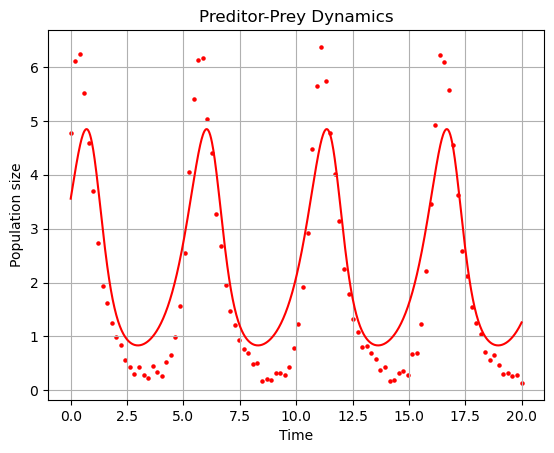

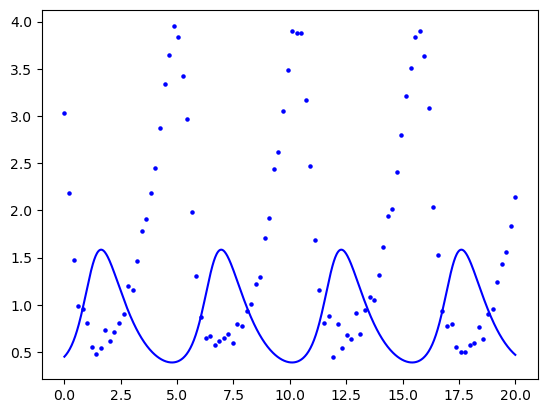

In [17]:
alpha_sim = params[0]
beta_sim = params[1]
delta_sim = params[2]
gamma_sim = params[3]

y0 = [params[4],params[5]]
t = np.linspace(t[0], t[-1], 1000)

output = odeint(lotka_volterra, y0, t, args=(alpha_sim, beta_sim, delta_sim, gamma_sim))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

plt.show()

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')

plt.show()

**Tuning**

In [39]:
# Parameter tuning for T_start

# init_guess = np.random.uniform(0,1,6)
n_iterations = 1000
std = 0.5
min_function = loss_function_res
# T_start = 20
a = 3
b = 10
data = df

T_range = np.arange(1,20,2)
runs = 0

err_list = []
std_list = []
for T_start in T_range:
    print(T_start)

    err_temp = []
    for _ in range(runs):
        init_guess = np.random.uniform(0,1,6)
        params, err = simulated_annealing(init_guess, n_iterations, std, min_function, T_start, a, b, data)
        err_temp.append(err)

    err_list.append(np.mean(err_temp))
    std_list.append(np.std(err_temp))

1
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1559260721482D+02   r2 =  0.7829790138330D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1559260721482D+02   r2 =  0.7829790138330D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1559260721482D+02   r2 =  0.6482929912039D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1559260721482D+02   r2 =  0.6482929912039D-15
 lsoda--  warning..internal t (=r1

/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_77223/1015864847.py:24: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-min_function(new_sol,data)+min_function(prev_sol,data))/T),1):


3
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6878137856369D+01   r2 =  0.4283969910807D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6878137856369D+01   r2 =  0.4283969910807D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6878137856369D+01   r2 =  0.4283969910807D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6878137856369D+01   r2 =  0.4283969910807D-15
 lsoda--  warning..internal t (=r1

/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_77223/1603972001.py:35: RuntimeWarning: overflow encountered in scalar power
  res = (x_data - x_model)**2 + (y_data - y_model)**2


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3642919986171D+01   r2 =  0.2206643339808D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3642919986171D+01   r2 =  0.2206643339808D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3642919986171D+01   r2 =  0.1827062265852D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3642919986171D+01   r2 =  0.1827062265852D-15
 lsoda--  warning..internal t (=r1) 

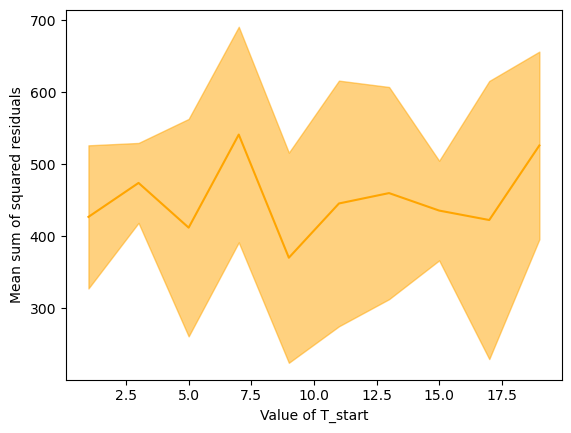

In [40]:
plt.plot(T_range, err_list, color = 'orange')
plt.fill_between(T_range, np.array(err_list)-np.array(std_list), np.array(err_list)+np.array(std_list), color = 'orange', alpha = 0.5)
plt.xlabel('Value of T_start')
plt.ylabel('Mean sum of squared residuals')
plt.show()

In [28]:
# Parameter tuning for std

# init_guess = np.random.uniform(0,1,6)
n_iterations = 1500
# std = 0.5
min_function = loss_function_res
T_start = 2
a = 3
b = 10
data = df

std_range = np.arange(0.001,1,0.1)
runs = 30

err_list = []
std_list = []
for std in std_range:
    print(std)

    err_temp = []
    for _ in range(runs):
        init_guess = np.random.uniform(0,1,6)
        params, err = simulated_annealing(init_guess, n_iterations, std, min_function, T_start, a, b, data)
        err_temp.append(err)

    err_list.append(np.mean(err_temp))
    std_list.append(np.std(err_temp))

0.001


/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_87614/1015864847.py:24: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-min_function(new_sol,data)+min_function(prev_sol,data))/T),1):
/Users/loesbijman/anaconda3/envs/my-env/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.101
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1781133391980D+02   r2 =  0.1543514211149D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1781133391980D+02   r2 =  0.1543514211149D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1781133391980D+02   r2 =  0.1278002892967D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1781133391980D+02   r2 =  0.1278002892967D-14
 lsoda--  warning..internal t 

/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_87614/1603972001.py:35: RuntimeWarning: overflow encountered in scalar power
  res = (x_data - x_model)**2 + (y_data - y_model)**2


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1523569388608D+02   r2 =  0.8726650429700D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1523569388608D+02   r2 =  0.8726650429700D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1339626965451D+02   r2 =  0.8235483659852D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1339626965451D+02   r2 =  0.8235483659852D-15
 lsoda--  warning..internal t (=r1) 

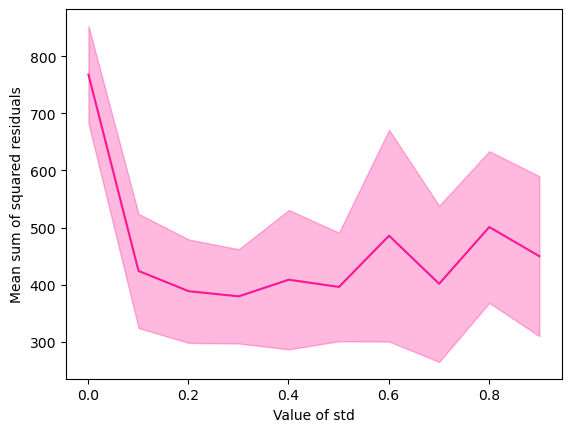

In [29]:
plt.plot(std_range, err_list, color = 'deeppink')
plt.fill_between(std_range, np.array(err_list)-np.array(std_list), np.array(err_list)+np.array(std_list), color = 'deeppink', alpha = 0.3)
plt.xlabel('Value of std')
plt.ylabel('Mean sum of squared residuals')
plt.show()

**Stochastic hill climbing**

Chooses at random from uphill moves (steepness determines probability of selection)

In [96]:
def stoch_hill_climb(init_guess, std, min_function, data, n_iterations):
    prev_sol = init_guess

    for _ in range(n_iterations):
        # create a new solution
        new_sol = []
        for param in prev_sol:
            new_param = param + np.random.normal(0,std)
            new_sol.append(new_param)

        # determine whether new_sol is accepted
        u = np.random.uniform()
        if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):
            prev_sol = new_sol

    return prev_sol

In [99]:
init_guess = np.ones(4)
std = 0.1
min_function = abs_residual
data = df
n_iterations = 10000

params_shc = stoch_hill_climb(init_guess,std,min_function,data,n_iterations)

/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_54516/2068039739.py:13: RuntimeWarning: overflow encountered in exp
  if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):
/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_54516/2068039739.py:13: RuntimeWarning: invalid value encountered in scalar divide
  if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):


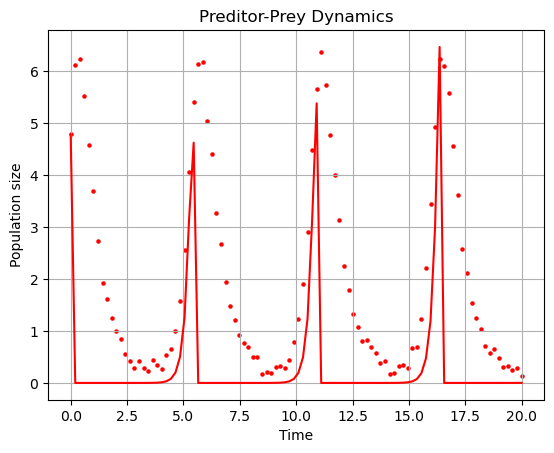

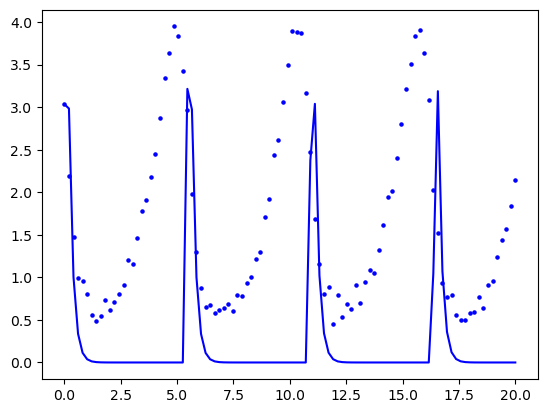

In [100]:
alpha_shc = params_shc[0]
beta_shc = params_shc[1]
delta_shc = params_shc[2]
gamma_shc = params_shc[3]

y0 = [x[0], y[0]]
t = np.linspace(t[0], t[-1], num=len(t))

output_shc = odeint(lotka_volterra, y0, t, args=(alpha_shc, beta_shc, delta_shc, gamma_shc))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

plt.show()

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')

plt.show()